**EDA - Exploratory Data Analyses**

1. **Общий обзор датасета**

In [1]:
import gc
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../')

from utils import read_parquet_dataset_from_local, eda_value_counts

In [2]:
TRAIN_TRANSACTIONS_PATH = '/media/DATA/AlfaBattle/train_transactions_contest/'
TEST_TRANSACTIONS_PATH = '/media/DATA/AlfaBattle/test_transactions_contest/'

TRAIN_TARGET_PATH = '/media/DATA/AlfaBattle/train_target.csv'
PRE_TRANSACTIONS_PATH = '/media/DATA/AlfaBattle/preprocessed_transactions/'
PRE_TEST_TRANSACTIONS_PATH = '/media/DATA/AlfaBattle/preprocessed_test_transactions/'

In [3]:
dataset_paths = sorted([os.path.join(TRAIN_TRANSACTIONS_PATH, filename) for filename in os.listdir(TRAIN_TRANSACTIONS_PATH) 
                              if filename.startswith('part')])
print(f'There are {len(dataset_paths)} files with transactions data')

There are 50 files with transactions data


Данные с транзакциями разбиты по 50 файлам, но их структура одинакова. Поэтому для определения типа данных достаточно 
считать один файл.  
Функция read_parquet_dataset_from_local читает заданное количество партиций форамате Parquet,  
преобразует их к pd.DataFrame и возвращает полученный DataFrame.

In [4]:
df = read_parquet_dataset_from_local(TRAIN_TRANSACTIONS_PATH, start_from=0, num_parts_to_read=1)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5408648 entries, 0 to 5408647
Data columns (total 20 columns):
 #   Column                Dtype  
---  ------                -----  
 0   app_id                int32  
 1   amnt                  float64
 2   currency              int32  
 3   operation_kind        int32  
 4   card_type             int32  
 5   operation_type        int32  
 6   operation_type_group  int32  
 7   ecommerce_flag        int32  
 8   payment_system        int32  
 9   income_flag           int32  
 10  mcc                   int32  
 11  country               int32  
 12  city                  int32  
 13  mcc_category          int32  
 14  day_of_week           int32  
 15  hour                  int32  
 16  days_before           int32  
 17  weekofyear            int32  
 18  hour_diff             int64  
 19  transaction_number    int32  
dtypes: float64(1), int32(18), int64(1)
memory usage: 453.9 MB


Объем занимаемой памяти около 500 Мб. Если загрузить все 50 партиций это потребует почти 25 Гб памяти только для хранения  
датафрейма, поэтому его обработка на большинстве машин будет невозможна. Партиции организованы таким образом,  
что для конкретного клиента вся информация о его транзакциях до момента подачи заявки на кредит расположена внутри  
одной партиции (транзакции сгруппированы по полю app_id). Это позволяет загружать данные в память кусками, выделять  
все необходимые признаки и получать результирующий фрейм для моделирования

Предоставленное описание данных:

app_id - Идентификатор заявки. заявки пронумерованы так, что более поздним заявкам соответствует более поздняя дата  
amnt - Нормированная сумма транзакции. 0.0 - соответствует пропускам  
 currency - Идентификатор валюты транзакции  
 operation_kind - Идентификатор типа транзакции  
 card_type - Уникальный идентификатор типа карты   
operation_type - Идентификатор типа операции по пластиковой карте  
operation_type_group - Идентификатор группы карточных операций, например, дебетовая карта или кредитная карта  
ecommerce_flag - Признак электронной коммерции  
payment_system - Идентификатор типа платежной системы  
income_flag - Признак списания/внесения денежных средств на карту  
 mcc - Уникальный идентификатор типа торговой точки  
 country - Идентификатор страны транзакции  
city - Идентификатор города транзакции  
mcc_category - Идентификатор категории магазина транзакции  
day_of_week - День недели, когда транзакция была совершена  
hour - Час, когда транзакция была совершена  
days_before - Количество дней до даты выдачи кредита  
weekofyear - Номер недели в году, когда транзакция была совершена  
hour_diff - Количество часов с момента прошлой транзакции для данного клиента  
transaction_number - Порядковый номер транзакции клиента  



Проверим данные на наличие пропусков:

In [6]:
missing_values = 0
for i in range(1, 50):
    df_temp = read_parquet_dataset_from_local(TRAIN_TRANSACTIONS_PATH, start_from=i, num_parts_to_read=1)
    missing_values += df_temp.isna().any().sum()
print(f'There are {missing_values} columns in dataset with missing \
values.')

There are 0 columns in dataset with missing values.


Пропусков в "чистом" виде нет, из описания данных следует, что сумма транзакции 0.0 соответсвует пропускам.  
Оценим сколько таких пропусков имеется в датасете.

In [7]:
missing_values = 0
total_rows = 0
for i in range(1, 50):
    df_temp = read_parquet_dataset_from_local(TRAIN_TRANSACTIONS_PATH, start_from=i, num_parts_to_read=1)
    missing_values += len(df_temp[df_temp['amnt'] == 0])
    total_rows += len(df_temp)
print(f'There are {missing_values} rows in dataset with missing \
values.')
print(f'There are {total_rows} rows in dataset.')
print(f'It\'s {(missing_values/total_rows)*100} percent missing values')

There are 1240279 rows in dataset with missing values.
There are 265041417 rows in dataset.
It's 0.46795667410727737 percent missing values


Поскольку пропусков менее процента и они не являются пропусками в чистом виде, на первом этапе можно оставить  
их в датасете, возможно из этих данных извлекутся скрытые закономерности.

**2. Анализ признаков датасета**

Из описания признак amnt является нормированной величиной суммы транзакции по карте.  
Проверим это на случайном клиенте.


In [8]:
# Случайно выберем номер партиции из диапазона 0 - 50
n = np.random.randint(50)
df_temp = read_parquet_dataset_from_local(TRAIN_TRANSACTIONS_PATH, start_from=n, num_parts_to_read=1)

In [9]:
nn = np.random.randint(df_temp.app_id.max() - df_temp.app_id.min())
df_temp = df_temp[df_temp['app_id'] == (nn + df_temp.app_id.min())]

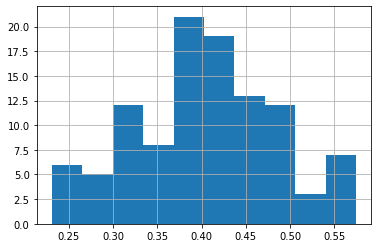

In [10]:
df_temp['amnt'].hist()
plt.show()

3. Теперь посмотрим на целочисленные переменные:

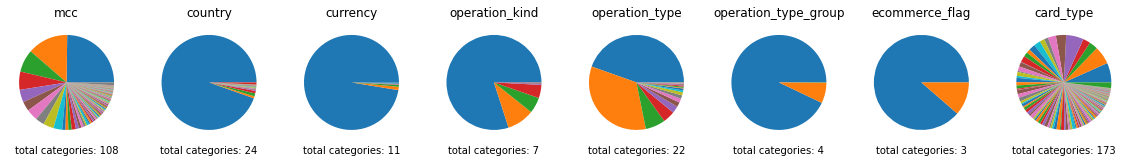

In [22]:
cat_list = ['mcc', 'country', 'currency', 'operation_kind', 'operation_type', 'operation_type_group', 'ecommerce_flag','card_type']
i = 0
plt.figure(figsize=(20,10))
for cl in cat_list:
    x = eda_value_counts(TRAIN_TRANSACTIONS_PATH, 50, cl)
    ax=plt.subplot(1, len(cat_list), i:= i+1, title=cl, xlabel=f'total categories: {len(x)}')
    plt.pie(x)

plt.show()



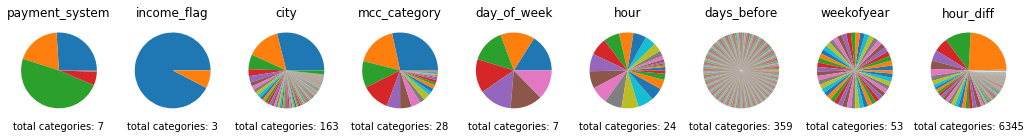

In [23]:
cat_list2 = ['payment_system', 'income_flag', 'city', 'mcc_category', 'day_of_week', 'hour', 'days_before', 'weekofyear', 'hour_diff']
i = 0
plt.figure(figsize=(18,10))
for cl in cat_list2:
    x = eda_value_counts(TRAIN_TRANSACTIONS_PATH, 50, cl)
    ax=plt.subplot(1, len(cat_list2), i:= i+1, title=cl, xlabel=f'total categories: {len(x)}')
    plt.pie(x)
plt.show()

Выводы:  
  
amnt - нормированный числовой признак, тип данных: float  
hour_diff, days_before - числовые признаки, тип данных: int  
Остальные признаки являются категорийными, уже переведенными в числовую форму.  
Но над данными необходимо поработать для их подачи в нейросеть или деревья решений типа CatBoost.  

Этому будет посвящен следующий ноутбук: preprocessing.ipynb



